In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from time import time
import mpmath as mp
from numba import njit
from scipy.integrate import quad
from scipy.optimize import root
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
import pyodbc

In [2]:
class VanillaOption():

    def __init__(self, r, S, k, t):
        self.r = r
        self.S = S
        self.k = k
        self.t = t
        
        
class VanillaCall(VanillaOption):
    @property
    def price(self):
        return np.mean(np.maximum(self.S[:,-1] - self.k, 0)*np.exp(-self.r*self.t))
    
    
class VanillaPut(VanillaOption):
    @property
    def price(self):
        return np.mean(np.maximum(strike - equity[:,-1], 0)*np.exp(-discount))

In [3]:
class BSEuroOption():

    def __init__(self, r, q, S, sigma, k, t):
        self.r = r
        self.q = q
        self.S = S
        self.sigma = sigma
        self.k = k
        self.t = t
        
        
    def d1(self, s=None, tau=None): 
        if s is None:
            s=self.S
        if tau is None:
            tau=self.t
        return ((np.log(s / self.k) + (self.r- self.q + np.square(self.sigma) / 2) * tau)) / (self.sigma * np.sqrt(tau))
    
    
    def d2(self, s=None, tau=None): 
        if s is None:
            s=self.S
        if tau is None:
            tau=self.t
        return self.d1(s, tau) - self.sigma * np.sqrt(tau)

    
    def gamma(self, s=None, tau=None):
        if s is None:
            s=self.S
        if tau is None:
            tau=self.t
        return np.exp(- self.q * tau) * norm.pdf(self.d1(s,tau)) / (self.sigma * s * np.sqrt(tau)) 

     
    def vega(self, s=None, tau=None):
        if s is None:
            s=self.S
        if tau is None:
            tau=self.t
        return np.exp(- self.q * tau) * s * np.sqrt(tau) *  norm.pdf(self.d1(s, tau)) / 100
        
     
    def vanna(self, s=None, tau=None):
        if s is None:
            s=self.S
        if tau is None:
            tau=self.t
        return np.exp(- self.q * tau) * np.sqrt(s) *  norm.pdf(self.d1(s,tau)) * (self.d2(s,tau)/self.sigma) / 100
    
     
    def volga(self,s=None, tau=None):
        if s is None:
            s=self.S
        if tau is None:
            tau=self.t
        return np.exp(- self.q * tau) * np.sqrt(s) *  norm.pdf(self.d1(s,tau)) * (self.d1(s,tau)*self.d2(s,tau)/self.sigma) / 100

class BSCall(BSEuroOption):

    
    def price(self, s=None, tau=None):
        if s is None:
            s=self.S
        if tau is None:
            tau=self.t
        # S * N(d1) - K * N(d2)
        return s * np.exp(-self.q * tau) * norm.cdf(self.d1(s,tau)) - self.k * np.exp(-self.r * tau) * norm.cdf(self.d2(s,tau))

    
    def delta(self,s=None, tau=None):
        if s is None:
            s=self.S
        if tau is None:
            tau=self.t
        return np.exp(- self.q * tau) * norm.cdf(self.d1(s,tau)) 

   
    
class BSPut(BSEuroOption):


    def price(self, s=None, tau=None):
        if s is None:
            s=self.S
        if tau is None:
            tau=self.t
        return self.k * np.exp(-self.r * tau) * norm.cdf(-self.d2(s,tau)) - s * np.exp(-self.q * tau) * norm.cdf(-self.d1(s,tau)) 

     
    def delta(self, s=None, tau=None):
        if s is None:
            s=self.S
        if tau is None:
            tau=self.t
        return -1 * np.exp(- self.q * tau) * norm.cdf(-self.d1(s,tau))

In [4]:
EffectiveDate = "'2021-12-31'"
connstr = 'DRIVER={ODBC Driver 17 for SQL Server};SERVER=actuarialdata.nwie.net,1021;DATABASE=NFActCorp;Trusted_Connection=yes;'
query = "EXEC [EconData].[Curve_NominalRates_Get] " + EffectiveDate
query2 = "Exec NFActCorp.QRM.SHARED_VOL_SURFACE_PIVOT_GET 'Master'," + EffectiveDate + ", 'SPX'"
query3 = "Exec NFActCorp.QRM.BBG_Closes_Scalar_Get 'SPX INDEX', 'EQY_DVD_YLD_12M', " + EffectiveDate
query4 = "select [Input_EquityVolatility] "
query4 += "FROM EconData.vw_VCFStateParameters "
query4 +="WHERE [FundName] = 'NVIT ID Managed Growth' "
query4 += "and	[AlgorithmVersion] = 1.0 "
query4 += "and EffectiveDate = "
query4 += EffectiveDate
query4 += " order by EffectiveDate"
rates = []
ivol = []
div = []
vol = []
with pyodbc.connect(connstr) as cnxn:

    with cnxn.cursor() as crs:
        crs.execute(query)
        for row in crs:
            rates.append(row)
    with cnxn.cursor() as crs:
        crs.execute(query2)
        for row in crs:
            ivol.append(row)
    with cnxn.cursor() as crs:
        crs.execute(query3)
        for row in crs:
            div.append(row)
    with cnxn.cursor() as crs:
        crs.execute(query4)
        for row in crs:
            vol.append(row)        
iVols_1yr = np.array(ivol[:][:][11][3:])
rate_1yr = rates[0][4] / 100
q = div[0][0] / 100
v0 = vol[0][0]

In [5]:
iVol_surf = np.zeros((21,11))
for d in range(iVol_surf.shape[0]):
    iVol_surf[d,:] = np.array(ivol[:][:][d][3:])
K = np.array([0.5, 0.6, 0.7, 0.8, 0.90, 1.00, 1.10, 1.2, 1.3, 1.4, 1.5])
T = np.array([1/12, 2/12, 0.25, 1/3, 5/12, 6/12, 7/12, 8/12, 9/12, 10/12, 11/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

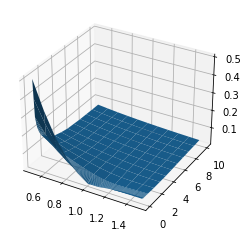

In [32]:
X, Y = np.meshgrid(K,T)
Z = iVol_surf**2

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z)
plt.show()

In [39]:
from scipy import interpolate
f = interpolate.interp2d(X, Y, Z, kind='cubic')
xnew = np.arange(.01, 2.0, 1e-4)
ynew = np.arange(1/360, 10, 1/360)
Znew = f(xnew, ynew)
iVol_surf_interp = np.sqrt(Znew)


C:\Users\lewim17\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


In [37]:
iVol_surf

array([[0.70974582, 0.59107137, 0.47242798, 0.35987517, 0.2432495 ,
        0.12481325, 0.12688076, 0.16117464, 0.16843043, 0.17025311,
        0.17098269],
       [0.62827724, 0.52653346, 0.4248461 , 0.32891531, 0.2343381 ,
        0.13862785, 0.11914073, 0.14878229, 0.16956977, 0.17694455,
        0.17952646],
       [0.53906305, 0.45929555, 0.38025124, 0.30740276, 0.23523631,
        0.15318043, 0.11871152, 0.13591188, 0.14859861, 0.15727988,
        0.1615697 ],
       [0.51886644, 0.44452192, 0.37097529, 0.30346611, 0.23670476,
        0.16291305, 0.1238378 , 0.13467618, 0.14743372, 0.15723198,
        0.16447972],
       [0.49645981, 0.42777814, 0.35995082, 0.29798388, 0.23675719,
        0.1702022 , 0.12906736, 0.13389439, 0.14609953, 0.15613235,
        0.16338775],
       [0.47752777, 0.41398318, 0.35134379, 0.29434438, 0.23795431,
        0.17753725, 0.13491909, 0.13408152, 0.14557959, 0.15588244,
        0.16350811],
       [0.46537093, 0.40505159, 0.34567936, 0.29189102, 0.

In [41]:
def EuroPricer(strike, discount, optiontype, equity):
    if optiontype == 'C':
        Price = np.mean(np.maximum(equity[:,-1] - strike, 0)*np.exp(-discount))
    else:
        Price = np.mean(np.maximum(strike - equity[:,-1], 0)*np.exp(-discount))
    return Price

In [42]:
from abc import ABC, abstractmethod
from typing import Tuple, List, Sequence, Dict, Union
from scipy.optimize import minimize, OptimizeResult 
from scipy.optimize import Bounds
from random import seed
from scipy.optimize import least_squares

class OptionPricingModel(ABC):
    """
    Model that can be used to price Euoprean Vanilla Options.
    """
    
    def __init__(self):
        self._parameters = None
    
    @property
    def parameters(self) -> Sequence[float]:
        """
        The model parameters, returned as a list of real numbers.
        """
        return self._parameters

    
    @parameters.setter
    @abstractmethod
    def parameters(self, value: Sequence[float]):
        """
        The model parameters, returned as a list of real numbers.
        """
        pass
        
    
    @abstractmethod
    def simulate(self):
        pass   
        
        
    def calibrate(self, real_prices, strikes, maturities, weight: np.array=None):
        if weight is None:
            weight = np.ones(real_prices.shape)
        loss = self.get_loss_function(real_prices, weight, strikes, maturities, sims, simlen, cols, dt)
        sol = minimize(loss, self.parameters, options=self.options, bounds=self.bounds)
        self.parameters = res.x
        return res, self
        
    def loss_function_generator(self, real_prices, weight, strikes, maturities):    

        def _loss_function(parameters):
            np.random.seed(1234)
            self.parameters = parameters
            predicted = []
            for i in range(len(strikes)):
                predicted.append(self.analytical_price(self, self.s0*strikes[i], maturities[i]))
            return sum(weight*(real_prices - np.array(predicted, dtype=float))**2)
        return _loss_function    

In [43]:
class GBMSA(OptionPricingModel):
    
    def __init__(self, s0, v0, r, q, psi, kappa, rho, theta):
        super().__init__()
        self.r = r
        self.q = q
        self.s0 = s0
        self.v0 = v0
        self.psi = psi
        self.kappa = kappa
        self.rho = rho
        self.theta = theta
        self.bounds = ((0.10, 1.0), (0.5, 10.0), (-0.99, 0.99), (0.05, 1.0))
        self.options = {'gtol': 1e-6, 'disp': True}
        self.parameters = (self.psi, self.kappa, self.rho, self.theta, self.v0)
    
    @property
    def parameters(self) -> Sequence[float]:
        """
        The model parameters, returned as a list of real numbers.
        """
        return self._parameters
    
    @parameters.setter
    def parameters(self, value):
        if value is not None:
            self.psi = value[0]
            self.kappa = value[1]
            self.rho = value[2]
            self.theta = value[3]
            self.v0 = value[4]
            self._parameters = value

            
    def HESTON_VOL(self,rvs, nsim=100000, timesteps=360, maturity=1, psi=.3877, theta = 0.18*0.18, kappa = 2, v0 = .18):
        dt = maturity / timesteps
        v = np.zeros((nsim, timesteps+1))
        v[:,0] = v0*v0
        for n in range(timesteps):
            rv = rvs[:,n]
            v[:,n+1] = np.maximum(v[:,n] + kappa * (theta - v[:,n]) * dt + 
                                   psi * np.sqrt(v[:,n]) * rv * np.sqrt(dt),0.01)
                
        vol = np.sqrt(v)
        return vol

    def simulate(self, sims, T, dt):
        m = int(T/(1 * dt))
        equity = np.zeros((sims, m+1))
        X1 = np.random.randn(sims, m)
        X2 = np.random.randn(sims, m)
        X3 = self.rho * X1 + np.sqrt(1-self.rho*self.rho)*X2
        vol = self.HESTON_VOL(X1, sims, m, T, self.psi, self.theta, self.kappa, self.v0)
        equity[:, 1:] = (self.r-self.q-vol[:,0:-1]*vol[:,0:-1] / 2) * dt + vol[:,0:-1] * np.sqrt(dt) * X3
        return self.s0 * np.exp(equity.cumsum(axis=1))
    
    def heston_charfunc(self, phi, tau):

        # constants
        a = self.kappa*self.theta
        b = self.kappa

        # common terms w.r.t phi
        rspi = self.rho*self.psi*phi*1j

        # define d parameter given phi and b
        d = np.sqrt( (self.rho*self.psi*phi*1j - b)**2 + (phi*1j+phi**2)*self.psi**2 )

        # define g parameter given phi, b and d
        g = (b-rspi+d)/(b-rspi-d)

        # calculate characteristic function by components
        x1 = (self.r-self.q)*phi*1j*tau
        #exp1 = np.exp((self.r-self.q)*phi*1j*tau)
        term2 = self.s0**(phi*1j) * ( (1-g*np.exp(d*tau))/(1-g) )**(-2*a/self.psi**2)
        x2 = a*tau*(b-rspi+d)/self.psi**2 + (self.v0*self.v0)*(b-rspi+d)*( (1-np.exp(d*tau))/(1-g*np.exp(d*tau)) )/self.psi**2
        x = x1 + x2
        expx = np.exp(x)
        #exp2 = np.exp(x2)
        #exp2 = np.exp(a*tau*(b-rspi+d)/self.psi**2 + (self.v0*self.v0)*(b-rspi+d)*( (1-np.exp(d*tau))/(1-g*np.exp(d*tau)) )/self.psi**2)

        #return exp1*term2*exp2
        return expx*term2


    def integrand(self, phi, K, tau):
        
        numerator = np.exp((self.r-self.q)*tau)*self.heston_charfunc(phi-1j,tau) - K*self.heston_charfunc(phi,tau)
        denominator = 1j*phi*K**(1j*phi)
        return numerator/denominator


    def analytical_price(self, K, tau):
        args = (K, tau)
        
        real_integral, err = np.real( quad(self.integrand, 0, 1000, args=args, limit=1000) )

        return (self.s0 - K*np.exp(-(self.r-self.q)*tau))/2 + real_integral/np.pi

[49.52 40.07 30.88 22.21 14.22  7.3   2.47  0.62  0.21  0.08  0.03]
Elapsted time is 0.01 seconds.


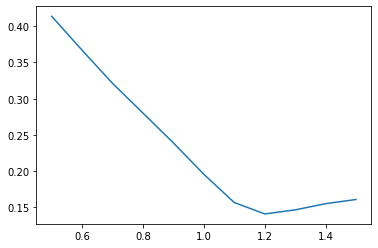

In [44]:
st = time()
r = rate_1yr
q = q
s0 = 100
strikes = np.array([0.5, 0.6, 0.7, 0.8, 0.90, 1.00, 1.10, 1.2, 1.3, 1.4, 1.5])
maturities = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
iVols = iVols_1yr
options = []
for i in range(len(iVols)):
    options.append(BSCall(r, q, s0, iVols[i], s0*strikes[i], maturities[i]))
real_prices = np.array([o.price() for o in options])
np.set_printoptions(precision=2, suppress=True)
print(real_prices)
print(f'Elapsted time is {time() - st:.2f} seconds.')
plt.plot(strikes, iVols)

In [45]:
np.arange(0,2,0.01)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
       1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.

Text(0.5, 1.0, 'BS Volga')

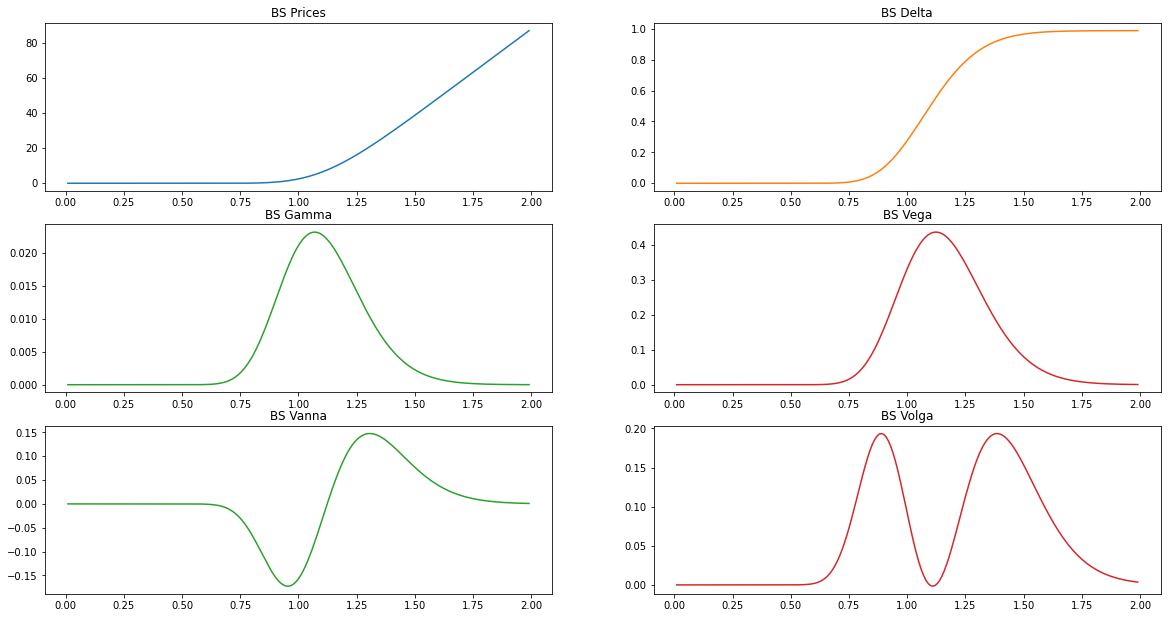

In [46]:
ATM = BSCall(r, q, s0, iVols[6], s0*strikes[6], maturities[6])
X = np.arange(0.01,2,0.01)
price_array = np.array([ATM.price(s0*x) for x in X])
delta_array = np.array([ATM.delta(s0*x) for x in X])
gamma_array = np.array([ATM.gamma(s0*x) for x in X])
vega_array = np.array([ATM.vega(s0*x) for x in X])
vanna_array = np.array([ATM.vanna(s0*x) for x in X])
volga_array = np.array([ATM.volga(s0*x) for x in X])
fig, axs = plt.subplots(3, 2)
fig.set_size_inches(20, 10.5)
x = X
axs[0, 0].plot(x, price_array)
axs[0, 0].set_title('BS Prices')
axs[0, 1].plot(x, delta_array, 'tab:orange')
axs[0, 1].set_title('BS Delta')
axs[1, 0].plot(x, gamma_array, 'tab:green')
axs[1, 0].set_title('BS Gamma')
axs[1, 1].plot(x, vega_array, 'tab:red')
axs[1, 1].set_title('BS Vega')
axs[2, 0].plot(x, vanna_array, 'tab:green')
axs[2, 0].set_title('BS Vanna')
axs[2, 1].plot(x, volga_array, 'tab:red')
axs[2, 1].set_title('BS Volga')

Text(0.5, 1.0, 'BS Volga')

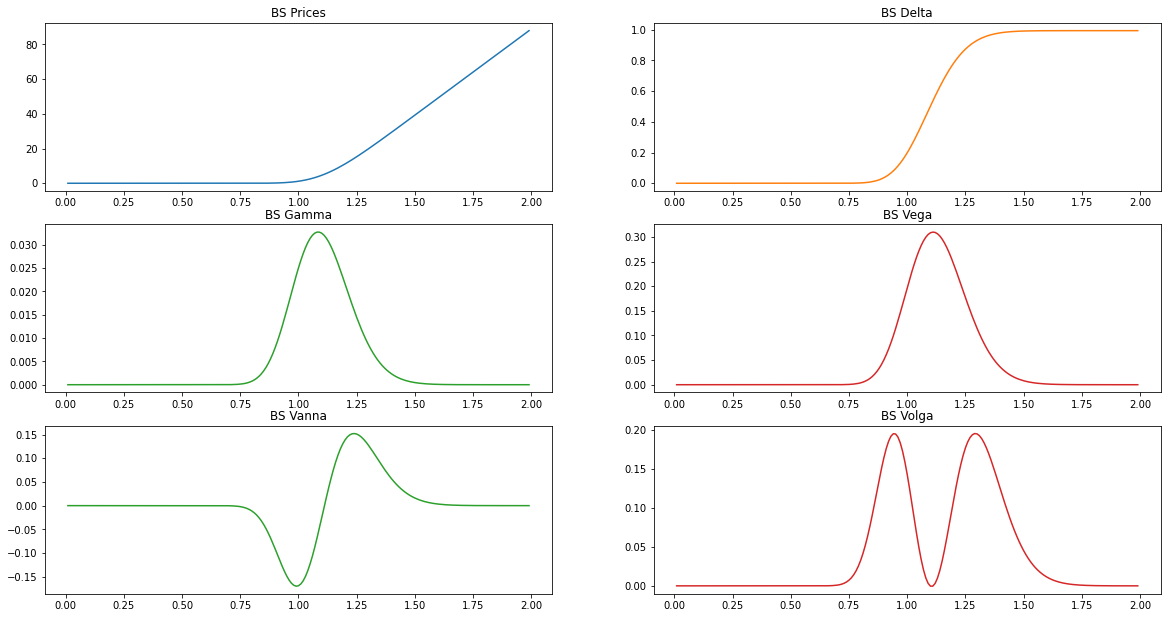

In [47]:
ATM = BSCall(r, q, s0, iVols[6], s0*strikes[6], maturities[6])
X = np.arange(0.01,2,0.01)
price_array = np.array([ATM.price(s0*x, 0.5) for x in X])
delta_array = np.array([ATM.delta(s0*x, 0.5) for x in X])
gamma_array = np.array([ATM.gamma(s0*x, 0.5) for x in X])
vega_array = np.array([ATM.vega(s0*x, 0.5) for x in X])
vanna_array = np.array([ATM.vanna(s0*x, 0.5) for x in X])
volga_array = np.array([ATM.volga(s0*x, 0.5) for x in X])
fig, axs = plt.subplots(3, 2)
fig.set_size_inches(20, 10.5)
x = X
axs[0, 0].plot(x, price_array)
axs[0, 0].set_title('BS Prices')
axs[0, 1].plot(x, delta_array, 'tab:orange')
axs[0, 1].set_title('BS Delta')
axs[1, 0].plot(x, gamma_array, 'tab:green')
axs[1, 0].set_title('BS Gamma')
axs[1, 1].plot(x, vega_array, 'tab:red')
axs[1, 1].set_title('BS Vega')
axs[2, 0].plot(x, vanna_array, 'tab:green')
axs[2, 0].set_title('BS Vanna')
axs[2, 1].plot(x, volga_array, 'tab:red')
axs[2, 1].set_title('BS Volga')

Text(0.5, 1.0, 'BS Volga')

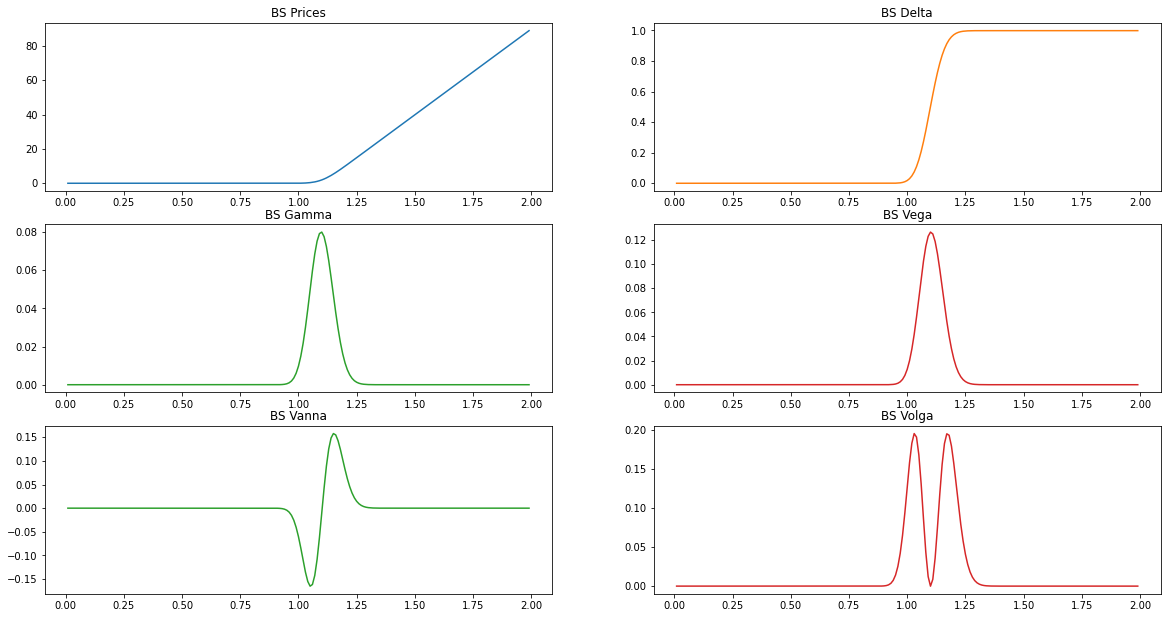

In [48]:
ATM = BSCall(r, q, s0, iVols[6], s0*strikes[6], maturities[6])
X = np.arange(0.01,2,0.01)
price_array = np.array([ATM.price(s0*x, 1/12) for x in X])
delta_array = np.array([ATM.delta(s0*x, 1/12) for x in X])
gamma_array = np.array([ATM.gamma(s0*x, 1/12) for x in X])
vega_array = np.array([ATM.vega(s0*x, 1/12) for x in X])
vanna_array = np.array([ATM.vanna(s0*x, 1/12) for x in X])
volga_array = np.array([ATM.volga(s0*x, 1/12) for x in X])
fig, axs = plt.subplots(3, 2)
fig.set_size_inches(20, 10.5)
x = X
axs[0, 0].plot(x, price_array)
axs[0, 0].set_title('BS Prices')
axs[0, 1].plot(x, delta_array, 'tab:orange')
axs[0, 1].set_title('BS Delta')
axs[1, 0].plot(x, gamma_array, 'tab:green')
axs[1, 0].set_title('BS Gamma')
axs[1, 1].plot(x, vega_array, 'tab:red')
axs[1, 1].set_title('BS Vega')
axs[2, 0].plot(x, vanna_array, 'tab:green')
axs[2, 0].set_title('BS Vanna')
axs[2, 1].plot(x, volga_array, 'tab:red')
axs[2, 1].set_title('BS Volga')

In [52]:
np.random.seed(12345)
st = time()
v0 = 0.2
psi = .1
kappa = 0.1
rho = -0.5
theta = v0**2
s0 = 100
T = 1
r = 0.001
q = 0.0163
drift = r - q
h_prices= []
heston = GBMSA(s0, v0, r, q, psi, kappa, rho, theta)
for s in range(len(strikes)):
    p = heston.analytical_price(strikes[s]*s0, T)
    print(f'${p:.2f} ----- ${real_prices[s]:.2f}')
    h_prices.append(p)
print(f'Elapsted time is {time() - st:.2f} seconds.')
print(f'Initial Sum of Squared Error for {len(real_prices)} market options is {sum((h_prices - real_prices)**2):.2f}.')

$48.12 ----- $49.52
$38.14 ----- $40.07
$28.48 ----- $30.88
$19.64 ----- $22.21
$12.30 ----- $14.22
$6.95 ----- $7.30
$3.60 ----- $2.47
$1.80 ----- $0.62
$0.96 ----- $0.21
$0.58 ----- $0.08
$0.40 ----- $0.03
Elapsted time is 0.13 seconds.
Initial Sum of Squared Error for 11 market options is 25.41.


In [61]:
def loss_function_generator(model, real_prices, weight, strikes, maturities):    

        def _loss_function(params):
            np.random.seed(1234)
            params_=np.array(params)
            model.parameters = params_
            predicted = []
            for i in range(len(strikes)):
                predicted.append(model.analytical_price(model.s0*strikes[i], maturities[i]))
            return np.sum(weight*(real_prices - np.array(predicted, dtype=float))**2)
        return _loss_function    

In [62]:
v0 = 0.5
psi = .49
kappa = 2.0
rho = -0.75
theta = v0**2
s0 = 100
T = 1
r = 0.001
q = 0.0163
heston = GBMSA(s0, v0, r, q, psi, kappa, rho, theta)
for s in range(len(strikes)):
    p = heston.analytical_price(strikes[s]*s0, T)
    print(f'${p:.2f} ----- ${real_prices[s]:.2f}')

$50.13 ----- $49.52
$41.93 ----- $40.07
$34.57 ----- $30.88
$28.11 ----- $22.21
$22.54 ----- $14.22
$17.85 ----- $7.30
$13.95 ----- $2.47
$10.78 ----- $0.62
$8.23 ----- $0.21
$6.22 ----- $0.08
$4.64 ----- $0.03


In [63]:
%%time
v0 = 0.2
psi = 0.49
kappa = 2.0
rho = -0.75
theta = v0**2
s0 = 100
T = 1
r = 0.001
q = 0.0163
heston = GBMSA(s0, v0, r, q, psi, kappa, rho, theta)
initial_condition = list(heston.parameters)
weight = np.ones(real_prices.shape)
cost_function = loss_function_generator(heston, real_prices, weight, strikes, maturities)
bnds = ((0.01, 1.0), (0.01, 15.0), (-1, 1), (0.05, 1.0), (0.01, 1.0))
sol = differential_evolution(cost_function, bounds=bnds, maxiter=100)

C:\Users\lewim17\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in exp
C:\Users\lewim17\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in cdouble_scalars
C:\Users\lewim17\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:96: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
C:\Users\lewim17\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: overflow encountered in exp
C:\Users\lewim17\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in cdouble_scalars
C:\Users\lewim17\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in exp
C:\Users\l

KeyboardInterrupt: 

In [36]:
print(f'Heston Psi :  {heston.parameters[0]:.2%}.')
print(f'Heston Kappa :  {heston.parameters[1]:.2f}.')
print(f'Heston Rho :  {heston.parameters[2]:.2%}.')
print(f'Heston Theta(vol) :  {np.sqrt(heston.parameters[3]):.2%}.')
print(f'Heston V0 :  {heston.parameters[4]:.2%}.')

Heston Psi :  nan%.
Heston Kappa :  nan.
Heston Rho :  nan%.
Heston Theta(vol) :  nan%.
Heston V0 :  nan%.


In [31]:
h2_prices= []
for s in range(len(strikes)):
    p = heston.analytical_price(strikes[s]*s0, T)
    print(f'${p:.2f} ----- ${real_prices[s]:.2f}')
    h2_prices.append(p)


$49.21 ----- $49.52
$39.90 ----- $40.07
$30.91 ----- $30.88
$22.32 ----- $22.21
$14.34 ----- $14.22
$7.27 ----- $7.30
$2.28 ----- $2.47
$0.77 ----- $0.62
$0.52 ----- $0.21
$0.42 ----- $0.08
$0.34 ----- $0.03


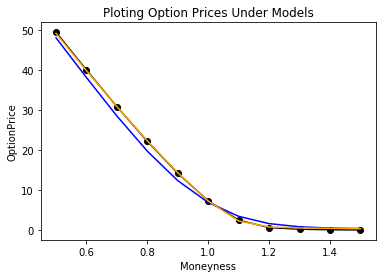

In [34]:
plt.plot(strikes,real_prices, color='black', marker='o')
plt.plot(strikes,h_prices, color='blue')
plt.plot(strikes,h2_prices, color='orange')
plt.title('Ploting Option Prices Under Models')
plt.xlabel('Moneyness')
plt.ylabel('OptionPrice')
plt.show()